In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
data = pd.read_csv('forestfires.csv')

In [3]:
data.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [4]:
data['size_category'] = data['size_category'].map({'small':0,'large':1})

In [5]:
data = data.iloc[:,2:]
x = data.drop('area', axis=1)
y = data['area']

In [6]:
scaler_x = StandardScaler()
x = pd.DataFrame(scaler_x.fit_transform(x), columns=x.columns)

In [7]:
x.shape

(517, 28)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier

In [12]:
def create_model(hidden_units=42, optimizer='adam',activation='relu',dropout_rate=0.0):
    model = Sequential([
        Dense(hidden_units, input_dim=28, activation=activation),
        Dropout(dropout_rate),
        Dense(1, activation='relu')
    ])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [13]:
param_grid = {'batch_size':[27,47,94], 
              'epochs':[10,50,100],
              'dropout_rate':[0.0,0.1,0.2],
              'optimizer':['adam','sgd'],
              'activation':['relu','tanh','linear']}

In [14]:
#from scikeras.wrappers import KerasClassifier
#model = KerasClassifier(build_fn=create_model, verbose=0)
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)

/tmp/ipykernel_4105/1681483163.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)


In [43]:
model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])

In [15]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=KFold(), verbose=10)
grid_result = grid.fit(x,y)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5; 1/162] START activation=relu, batch_size=27, dropout_rate=0.0, epochs=10, optimizer=adam
[CV 1/5; 1/162] END activation=relu, batch_size=27, dropout_rate=0.0, epochs=10, optimizer=adam;, score=0.442 total time=   4.3s
[CV 2/5; 1/162] START activation=relu, batch_size=27, dropout_rate=0.0, epochs=10, optimizer=adam
[CV 2/5; 1/162] END activation=relu, batch_size=27, dropout_rate=0.0, epochs=10, optimizer=adam;, score=0.000 total time=   1.2s
[CV 3/5; 1/162] START activation=relu, batch_size=27, dropout_rate=0.0, epochs=10, optimizer=adam
[CV 3/5; 1/162] END activation=relu, batch_size=27, dropout_rate=0.0, epochs=10, optimizer=adam;, score=0.058 total time=   1.1s
[CV 4/5; 1/162] START activation=relu, batch_size=27, dropout_rate=0.0, epochs=10, optimizer=adam
[CV 4/5; 1/162] END activation=relu, batch_size=27, dropout_rate=0.0, epochs=10, optimizer=adam;, score=0.010 total time=   1.1s
[CV 5/5; 1/162] START activat

In [16]:
print('Best: {}, using {}'.format(grid_result.best_score_, grid_result.best_params_))

Best: 0.35537714660167696, using {'activation': 'tanh', 'batch_size': 94, 'dropout_rate': 0.1, 'epochs': 10, 'optimizer': 'adam'}


<Axes: xlabel='param_epochs', ylabel='param_batch_size'>

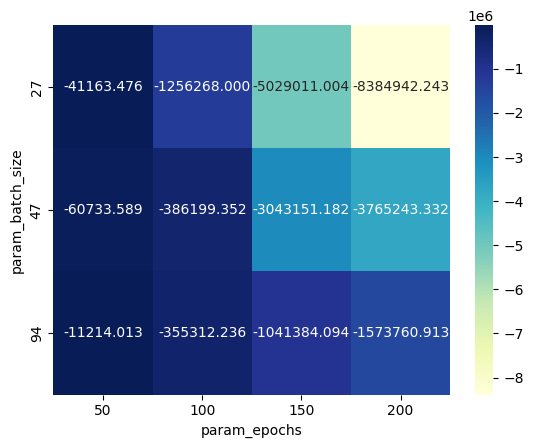

In [17]:
grid_result_df = pd.DataFrame(grid_result.cv_results_)
mean_scores = grid_result_df.pivot_table(values='mean_test_score', index='param_batch_size', columns='param_epochs')
sns.heatmap(mean_scores, cmap="YlGnBu", annot=True, fmt=".3f")

In [18]:
model = create_model(activation='tanh',dropout_rate=0.1,optimizer='adam')
history = model.fit(x,y,validation_split=0.2,epochs=10,batch_size=94)

Epoch 1/10
5/5 [==============================] - 1s 79ms/step - loss: 34.7797 - accuracy: 0.3148 - val_loss: 90.5157 - val_accuracy: 0.2308
Epoch 2/10
5/5 [==============================] - 0s 9ms/step - loss: -4.1996 - accuracy: 0.3269 - val_loss: 86.3406 - val_accuracy: 0.2308
Epoch 3/10
5/5 [==============================] - 0s 15ms/step - loss: 37.5437 - accuracy: 0.3148 - val_loss: 81.9546 - val_accuracy: 0.2308
Epoch 4/10
5/5 [==============================] - 0s 15ms/step - loss: 24.3402 - accuracy: 0.3099 - val_loss: 79.7833 - val_accuracy: 0.2212
Epoch 5/10
5/5 [==============================] - 0s 14ms/step - loss: 28.3884 - accuracy: 0.3099 - val_loss: 75.5603 - val_accuracy: 0.2115
Epoch 6/10
5/5 [==============================] - 0s 16ms/step - loss: 23.3449 - accuracy: 0.3148 - val_loss: 72.6147 - val_accuracy: 0.2115
Epoch 7/10
5/5 [==============================] - 0s 14ms/step - loss: 5.5772 - accuracy: 0.3002 - val_loss: 70.6124 - val_accuracy: 0.2115
Epoch 8/10
5/5 